In [1]:
'main'
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
'Data Visualization'
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

In [3]:
'Data Prep and Model Evaluation'
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
file = 'D:\\Python\\Machine Learning\\Unsupervised Learning using python Book 4\\datasets\\mnist.pkl.gz'

In [5]:
f = gzip.open(file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [6]:
# Split X and y value
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [7]:
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train) + len(X_validation), len(X_train) + len(X_validation) + len(X_test))

In [8]:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.DataFrame(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.DataFrame(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)

# PCA

In [9]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

# k-Means

In [10]:
from sklearn.cluster import KMeans

n_cluster = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[], index=range(2, 21), columns=['inertia'])

for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:, 0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

In [11]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on='cluster', right_on='cluster')
    overallAccuracy = accuracyDF.countMostFrequent.sum() / accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent / accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

## k-Means accuracy

In [12]:
n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[], index=range(2, 21), columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(2, 21), columns=['overallAccuracy'])

for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:, 0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:, 0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, \
    accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans


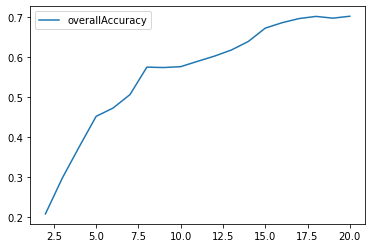

In [13]:
overallAccuracy_kMeansDF.plot()

## k-Means and PCA

In [14]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = cutoffNumber
    
    kmeans.fit(X_train_PCA.loc[:, 0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:, 0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, \
    accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

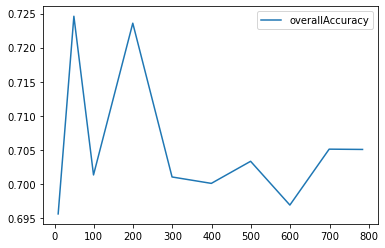

In [15]:
overallAccuracy_kMeansDF.plot()

## k-Mean comparsion with PCA

In [16]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:, 0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:, 0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, \
    accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  app.launch_new_instance()


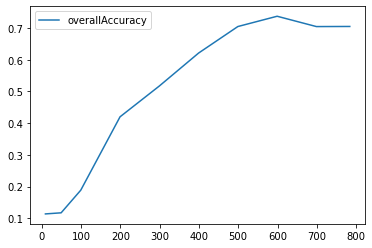

In [17]:
overallAccuracy_kMeansDF.plot()

# Hierarchical Clustering

In [18]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 100
Z = fastcluster.linkage_vector(X_train_PCA.loc[:, 0:cutoff], method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, columns=['clusterOne', 'clusterTwo', 'distance', 'newClusterSize'])

In [19]:
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.567125,2.0
1,28350.0,37674.0,0.592486,2.0
2,26696.0,44705.0,0.623958,2.0
3,12634.0,32823.0,0.627941,2.0
4,24707.0,43151.0,0.639226,2.0
5,20465.0,24483.0,0.664055,2.0
6,46542.0,49961.0,0.668583,2.0
7,466.0,42098.0,0.669491,2.0
8,2301.0,5732.0,0.674538,2.0
9,37564.0,47668.0,0.675124,2.0


In [20]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters, index=X_train_PCA.index, columns=['cluster'])

In [21]:
print('Number of distinct clusters: ', len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  22


In [22]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, accuracyDF_hierClust, overallAccuracy_hierClust, \
accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, y_train)

print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76674


# DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

eps =3 
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:, 0:cutoff])
X_train_PCA_dbscanClustered = pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, accuracyDF_dbscan, overallAccuracy_dbscan, \
accuracyByLabel_dbscan = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

print('Overall accuracy from DBSCAN clustering: ', overallAccuracy_dbscan)

Overall accuracy from DBSCAN clustering:  0.242


# HDBSCAN

In [25]:
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = hdb.fit_predict(X_train_PCA.loc[:, 0:cutoff])
X_train_PCA_hdbscanClustered = pd.DataFrame(data=X_train_PCA_hdbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, countMostFreq_hdbscan, accuracyDF_hdbscan, overallAccuracy_hdbscan, \
accuracyByLabel_hdbscan = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

print('Overall accuracy from HDBSCAN clustering: ', overallAccuracy_hdbscan)

ModuleNotFoundError: No module named 'hdbscan'